# Analyzing out-of-this world data, Part 2
Using data collected from the Open Exoplanet Catalogue database: https://github.com/OpenExoplanetCatalogue/open_exoplanet_catalogue/

## Data License
Copyright (C) 2012 Hanno Rein

Permission is hereby granted, free of charge, to any person obtaining a copy of this database and associated scripts (the "Database"), to deal in the Database without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Database, and to permit persons to whom the Database is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Database. A reference to the Database shall be included in all scientific publications that make use of the Database.

THE DATABASE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE DATABASE OR THE USE OR OTHER DEALINGS IN THE DATABASE.

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
planets = pd.read_csv('data/planets.csv')

Since we completed our EDA in the [planets_ml.ipynb notebook for last chapter](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/blob/master/ch_09/planets_ml.ipynb), we will just look at the first 5 rows to refresh our memory of the data rather than repeating the EDA here.

In [3]:
planets.head()

,period,name,eccentricity,description,discoverymethod,periastrontime,lastupdate,semimajoraxis,mass,periastron,list,discoveryyear
0,326.03,11 Com b,0.231,11 Com b is a brown dwarf-mass companion to th...,RV,2452899.60,15/09/20,1.290,19.400,94.800,Confirmed planets,2008.0
1,516.22,11 UMi b,0.080,11 Ursae Minoris is a star located in the cons...,RV,2452861.04,15/09/20,1.540,11.200,117.630,Confirmed planets,2009.0
2,185.84,14 And b,0.000,14 Andromedae is an evolved star in the conste...,RV,2452861.40,15/09/20,0.830,4.800,0.000,Confirmed planets,2008.0
3,1766.00,14 Her b,0.359,The star 14 Herculis is only 59 light years aw...,RV,NaN,15/09/21,2.864,4.975,22.230,Confirmed planets,2002.0
4,9886.00,14 Her c,0.184,14 Her c is the second companion in the system...,RV,NaN,15/09/21,9.037,7.679,189.076,Controversial,2006.0


## Predicting Length of Year (Period)

In [4]:
from sklearn.model_selection import train_test_split

data = planets[
    ['semimajoraxis', 'period', 'mass', 'eccentricity']
].dropna()
X = data[['semimajoraxis', 'mass', 'eccentricity']]
y = data.period

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

### Hyperparameter Tuning with GridSearchCV

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LinearRegression())
])

search_space = {
    'scale__with_mean' : [True, False], 'scale__with_std' : [True, False],
    'lr__fit_intercept': [True, False], 'lr__normalize' : [True, False]
}
grid = GridSearchCV(
    model_pipeline, search_space, cv=5,
    scoring={
        'r_squared': 'r2', 
        'mse' : 'neg_mean_squared_error', 
        'mae' : 'neg_mean_absolute_error',
        'rmse' : make_scorer(lambda x, y: np.sqrt(mean_squared_error(x, y)))
    }, refit='mae', iid=False
).fit(X_train, y_train)

In [6]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

Best parameter (CV score=-1605.538):
{'lr__fit_intercept': False, 'lr__normalize': True, 'scale__with_mean': False, 'scale__with_std': True}


Text(0.5, 0.98, 'Logistic Regression with Grid Search')

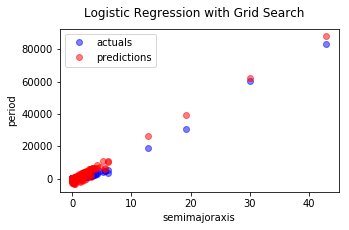

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
axes.plot(X_test.semimajoraxis, y_test, 'bo', label='actuals', alpha=0.5)
axes.plot(X_test.semimajoraxis, grid.predict(X_test), 'ro', label='predictions', alpha=0.5)
plt.xlabel('semimajoraxis')
plt.ylabel('period')
plt.legend()
plt.suptitle('Logistic Regression with Grid Search')

In [8]:
# mean absolute error
grid.score(X_test, y_test)

-1235.4924651855556

In [9]:
# r squared
grid.best_estimator_.score(X_test, y_test)

0.9227221271755528

### Regularization

In [10]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

ridge, lasso, elastic = Ridge(), Lasso(), ElasticNet()

for method in [ridge, lasso, elastic]:
    method.fit(X_train, y_train)
    print(
        f'{method.__class__.__name__}: '
        f'{method.score(X_test, y_test):.4}'
    )

Ridge: 0.9302
Lasso: 0.9298
ElasticNet: 0.9375
